In [6]:
import pandas as pd
import numpy as np
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from tqdm import tqdm
import shutil
from utils import count_parameters, accuracy
from config import NUM_EPOCHS, CV_DATA, TRAIN_DATA

import pyro
import pyro.distributions as dist
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate
from pyro.optim import Adam, ClippedAdam, SGD

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
%matplotlib inline

In [9]:
plt.style.use('ggplot')

In [18]:
train_data = pd.read_csv(TRAIN_DATA, delimiter='\t', header=None)
cv_data = pd.read_csv(CV_DATA, delimiter='\t', header=None)
df = pd.concat([train_data, cv_data], axis=0, ignore_index=True)

In [19]:
df

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
0,3,0.537303,0.531103,0.528503,0.529403,0.533603,0.540903,0.551103,0.564003,0.579603,...,0.547103,0.546903,0.545903,0.543903,0.541003,0.537203,0.532303,0.526403,0.519503,0.511403
1,3,0.588398,0.593898,0.599098,0.604098,0.608798,0.613397,0.617797,0.622097,0.626097,...,0.228799,0.237399,0.246499,0.256199,0.266499,0.277399,0.288799,0.300899,0.313599,0.326899
2,1,-0.049900,-0.041500,-0.033400,-0.025600,-0.018100,-0.010800,-0.003800,0.003000,0.009600,...,-0.185601,-0.173801,-0.161601,-0.149201,-0.136401,-0.123201,-0.109701,-0.095901,-0.081701,-0.067100
3,3,1.337005,1.319805,1.302905,1.286305,1.270005,1.254005,1.238304,1.223005,1.208104,...,1.278905,1.288905,1.298505,1.307705,1.316505,1.324905,1.332805,1.340205,1.347005,1.353205
4,3,0.769801,0.775301,0.780401,0.785101,0.789401,0.793301,0.796801,0.799901,0.802601,...,0.740801,0.742401,0.744501,0.747301,0.750701,0.754801,0.759501,0.765001,0.771301,0.778401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9231,3,0.723503,0.722803,0.722803,0.723603,0.725203,0.727403,0.730303,0.733903,0.738003,...,0.666102,0.668502,0.671702,0.675702,0.680402,0.686102,0.692602,0.700002,0.708403,0.717803
9232,3,0.629604,0.636304,0.643404,0.650704,0.658304,0.666204,0.674304,0.682504,0.691004,...,0.603404,0.603904,0.603804,0.603204,0.602104,0.600404,0.598204,0.595404,0.592004,0.588104
9233,1,0.602902,0.604202,0.605802,0.607502,0.609402,0.611402,0.613502,0.615902,0.618302,...,0.532902,0.538403,0.544002,0.549502,0.555002,0.560502,0.566002,0.571402,0.576802,0.582202
9234,2,-0.525899,-0.532599,-0.538699,-0.544299,-0.549399,-0.553999,-0.558199,-0.561899,-0.565199,...,-0.297599,-0.317699,-0.339999,-0.364799,-0.391999,-0.421799,-0.454199,-0.489399,-0.527399,-0.568299


In [23]:
df = df.drop(0, 1)

In [102]:
def pooling(mat,ksize,method='max',pad=False):
    '''Non-overlapping pooling on 2D or 3D data.

    <mat>: ndarray, input array to pool.
    <ksize>: tuple of 2, kernel size in (ky, kx).
    <method>: str, 'max for max-pooling, 
                   'mean' for mean-pooling.
    <pad>: bool, pad <mat> or not. If no pad, output has size
           n//f, n being <mat> size, f being kernel size.
           if pad, output has size ceil(n/f).

    Return <result>: pooled matrix.
    '''

    m, n = mat.shape[:2]
    ky,kx=ksize

    _ceil=lambda x,y: int(numpy.ceil(x/float(y)))

    if pad:
        ny=_ceil(m,ky)
        nx=_ceil(n,kx)
        size=(ny*ky, nx*kx)+mat.shape[2:]
        mat_pad=numpy.full(size,numpy.nan)
        mat_pad[:m,:n,...]=mat
    else:
        ny=m//ky
        nx=n//kx
        mat_pad=mat[:ny*ky, :nx*kx, ...]

    new_shape=(ny,ky,nx,kx)+mat.shape[2:]

    if method=='max':
        result=numpy.nanmax(mat_pad.reshape(new_shape),axis=(1,3))
    else:
        result=numpy.nanmean(mat_pad.reshape(new_shape),axis=(1,3))

    return result

In [104]:
xs = df.values.astype(np.float32)

In [107]:
import numpy

In [109]:
res = pooling(xs, (1,8))

In [112]:
xs.reshape(1,8).max(axis=1)

ValueError: cannot reshape array of size 9457664 into shape (1,8)

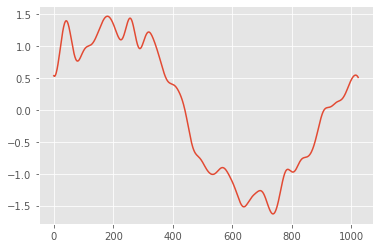

In [29]:
sns.lineplot(x=np.arange(len(v)), y=v)

In [75]:
y=v.reshape(16).max(axis=0)

ValueError: cannot reshape array of size 1024 into shape (16,)

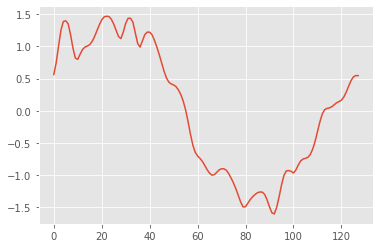

In [65]:
sns.lineplot(x=np.arange(len(y)), y=y)